<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/master/recipes/medical_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

# Kili Tutorial: Reading and uploading dicom image data

In this tutorial, we will show you how to upload medical images to Kili Technology. We will use [pydicom](https://pydicom.github.io/pydicom/stable/), a Python package that reads medical data in Dicom format.

Data used in this tutorial comes from the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data) hosted on Kaggle in 2018.

First of all, let's import the packages, and install pydicom in case you don't have it installed.

In [ ]:
!pip install pydicom matplotlib Pillow wget

In [ ]:
import os
import glob
from collections import defaultdict
import pickle
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches
from PIL import Image
import numpy as np
import pandas as pd
import wget
from pathlib import Path

Let's download some dicom images:

In [ ]:
wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/master/recipes/datasets/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm?raw=true"
)
wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/master/recipes/datasets/0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm?raw=true"
)
wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/master/recipes/conf/medical-labels.pkl?raw=true"
)

data_folder = Path(".")
files = list(data_folder.glob("*.dcm"))

100% [..............................................................................] 87203 / 87203

In [ ]:
print(files)

[PosixPath('0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm'), PosixPath('0005d3cc-3c3f-40b9-93c3-46231c3eb813 (1).dcm'), PosixPath('0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm'), PosixPath('0000a175-0e68-4ca4-b1af-167204a7e0bc (1).dcm'), PosixPath('0000a175-0e68-4ca4-b1af-167204a7e0bc (2).dcm'), PosixPath('0005d3cc-3c3f-40b9-93c3-46231c3eb813 (2).dcm')]


For each dicom image, we extract the dicom tags and add them to `metadata_array`:

In [ ]:
def dcm2metadata(sample):
    metadata = {}
    for key in sample.keys():
        if key.group < 50:
            item = sample.get(key)
            if hasattr(item, "description") and hasattr(item, "value"):
                metadata[item.description()] = str(item.value)
    return metadata


metadata_array = []

for file in files:
    sample = pydicom.dcmread(str(file))
    metadata_array.append(dcm2metadata(sample))

In [ ]:
print(metadata_array[0])

{'Specific Character Set': 'ISO_IR 100', 'SOP Class UID': '1.2.840.10008.5.1.4.1.1.7', 'SOP Instance UID': '1.2.276.0.7230010.3.1.4.8323329.1747.1517874292.605928', 'Study Date': '19010101', 'Study Time': '000000.00', 'Accession Number': '', 'Modality': 'CR', 'Conversion Type': 'WSD', "Referring Physician's Name": '', 'Series Description': 'view: PA', "Patient's Name": '0005d3cc-3c3f-40b9-93c3-46231c3eb813', 'Patient ID': '0005d3cc-3c3f-40b9-93c3-46231c3eb813', "Patient's Birth Date": '', "Patient's Sex": 'F', "Patient's Age": '22', 'Body Part Examined': 'CHEST', 'View Position': 'PA', 'Study Instance UID': '1.2.276.0.7230010.3.1.2.8323329.1747.1517874292.605927', 'Series Instance UID': '1.2.276.0.7230010.3.1.3.8323329.1747.1517874292.605926', 'Study ID': '', 'Series Number': '1', 'Instance Number': '1', 'Patient Orientation': '', 'Samples per Pixel': '1', 'Photometric Interpretation': 'MONOCHROME2', 'Rows': '1024', 'Columns': '1024', 'Pixel Spacing': '[0.14300000000000002, 0.143000000

We also convert all images to JPEG format:

In [ ]:
processed_imgs = []

for file in files:
    sample = pydicom.dcmread(str(file))
    im = Image.fromarray(sample.pixel_array)
    fpath = data_folder / f"{file.stem}.jpeg"
    im.save(str(fpath))
    processed_imgs.append(str(fpath))

In [ ]:
print(processed_imgs)

['0005d3cc-3c3f-40b9-93c3-46231c3eb813.jpeg', '0005d3cc-3c3f-40b9-93c3-46231c3eb813 (1).jpeg', '0000a175-0e68-4ca4-b1af-167204a7e0bc.jpeg', '0000a175-0e68-4ca4-b1af-167204a7e0bc (1).jpeg', '0000a175-0e68-4ca4-b1af-167204a7e0bc (2).jpeg', '0005d3cc-3c3f-40b9-93c3-46231c3eb813 (2).jpeg']


Next, we just need to connect to Kili, create a project, and define the annotation interface. You can also refine the interface in the Kili app.

In [ ]:
!pip install kili


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from kili.client import Kili

# Don't forget to set your 'KILI_API_KEY' environment variable with your API Key: os.environ['KILI_API_KEY'] = "<YOUR_API_KEY>"
# If you use Kili on-premise, be sure to set your 'KILI_API_ENDPOINT' environment variable.

kili = Kili()

In [ ]:
job_id = "JOB_0"

json_interface = {
    "jobs": {
        "CLASSIFICATION_JOB": {
            "mlTask": "CLASSIFICATION",
            "content": {
                "categories": {"YES": {"name": "Yes"}, "NO": {"name": "No"}},
                "input": "radio",
            },
            "required": 1,
            "isChild": False,
            "instruction": "Healthy ?",
        },
        "JOB_0": {
            "mlTask": "OBJECT_DETECTION",
            "content": {
                "categories": {
                    "BONE": {"name": "bone"},
                    "TISSUE": {"name": "tissue"},
                    "LUNG": {"name": "lung"},
                    "RIB": {"name": "rib"},
                },
                "input": "radio",
            },
            "required": True,
            "tools": ["semantic"],
            "instruction": "Segmentation",
        },
    }
}

We can now use the SDK to create our project and upload our images to the project.

In [ ]:
title = "Medical Imaging with Kili Technology"
description = "This is a test project"
input_type = "IMAGE"

project = kili.create_project(
    title=title, description=description, input_type=input_type, json_interface=json_interface
)
project_id = project["id"]

In [ ]:
kili.append_many_to_dataset(
    project_id=project_id,
    content_array=processed_imgs,
    json_metadata_array=metadata_array,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.79it/s]


{'id': 'cleodosin00au0j4th8fkh8vh'}

Done! Your images and their metadatas are in the project. All that remains is to start labeling!

Below, we'll show you how you can visualize labels with Python.

Here we do it with pre-saved labels but it could be done with your own labels, [see documentation](https://docs.kili-technology.com/docs/exporting-project-data).

In [ ]:
wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/master/recipes/conf/medical-labels.pkl?raw=true"
)

with open("medical-labels.pkl", "rb") as f:
    labels = pickle.load(f)

healthy = labels["CLASSIFICATION_JOB"]["categories"][0]["name"]
semantic = labels["JOB_0"]["annotations"]

100% [..............................................................................] 87203 / 87203

We convert those labels, and plot them using matplotlib:

In [ ]:
points = pd.DataFrame(semantic[0]["boundingPoly"][0]["normalizedVertices"]).values


def transform2image(points, shape):
    newpoints = np.zeros(points.shape)
    newpoints[:, 0] = points[:, 0] * shape[0]
    newpoints[:, 1] = points[:, 1] * shape[1]
    return newpoints


category2points = defaultdict(list)
for annotation in semantic:
    category = annotation["categories"][0]["name"]
    points = pd.DataFrame(annotation["boundingPoly"][0]["normalizedVertices"]).values
    category2points[category].append(points)

fname = os.path.split(files[0])[-1].split(".")[0]
im = Image.open(f"{data_folder}/{fname}.jpeg")

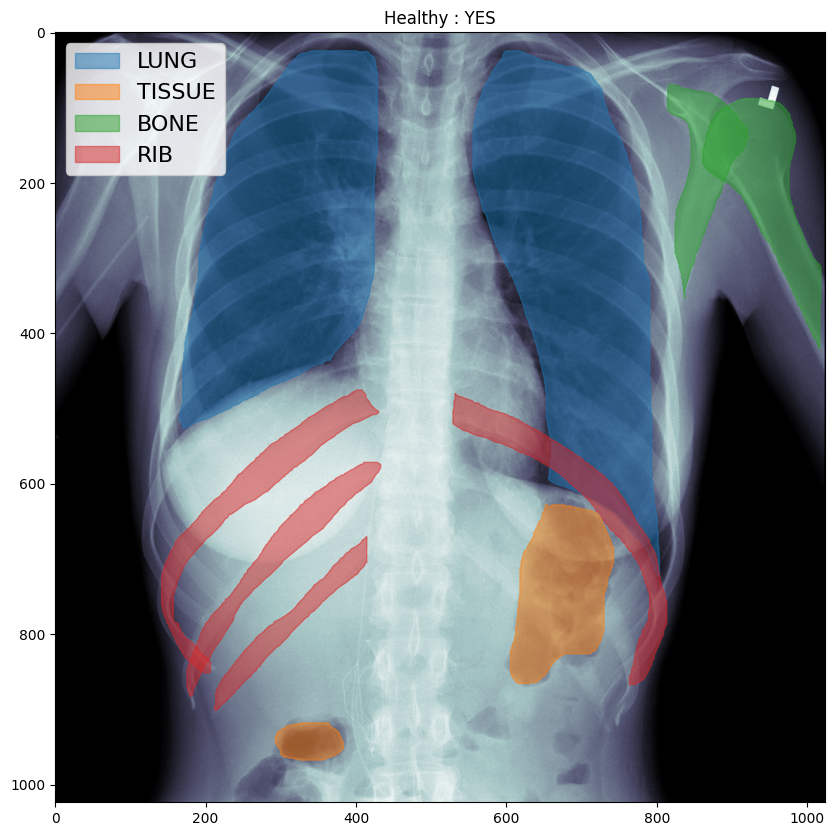

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, cmap=plt.cm.bone)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, (category, shapes) in enumerate(category2points.items()):
    for j, shape in enumerate(shapes):
        if j == 0:
            poly = matplotlib.patches.Polygon(
                transform2image(shape, im.size), color=colors[i], alpha=0.5, label=category
            )
        else:
            poly = matplotlib.patches.Polygon(
                transform2image(shape, im.size), color=colors[i], alpha=0.5
            )
        ax.add_patch(poly)
ax.legend(fontsize=16)
ax.set_title(f"Healthy : {healthy}");

## Project cleanup

In [ ]:
kili.delete_project(project_id)